In [32]:
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated, List, Literal
from langgraph.graph.message import add_messages, BaseMessage
from dotenv import load_dotenv

In [23]:
load_dotenv()

True

In [24]:
class chatState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [25]:
# create tools
@tool
def calculator(operator: Literal["add", "multiply", "divide", "subtract"], num1: int, num2: int) -> dict:
    """Calculate any arithmetic operation like add, divide, subtract and multiply"""
    try:
        if operator == "add":
            result = num1 + num2
        elif operator == "multiply":
            result = num1 * num2
        elif operator == "subtract":
            result =  num1 - num2
        elif operator == "divide":
            if num2 == 0:
                return {"error": "Division by zero is not allowed!"}
            result = num1/num2
        else:
            return {"error": f"Unsupported Operation {operator}"}

        return {"num1": num1, "num2": num2, "operation": operator, "result": result}
    except Exception as e:
        return {"error": str(e)}
    
search_tool = DuckDuckGoSearchRun()

In [26]:
tools = [calculator, search_tool]
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0.7)
llm_with_tool = llm.bind_tools(tools)

In [36]:
def chat_node(state: chatState):
    output = llm_with_tool.invoke(state["messages"])
    return {"messages": [output]}

tool_node = ToolNode(tools)

In [73]:
graph = StateGraph(chatState)

graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)

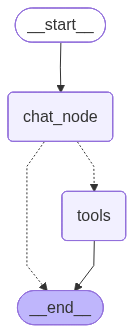

In [74]:
workflow = graph.compile()
workflow

In [75]:
initial_state = {
    "messages": [HumanMessage(content="Hi how are you?")]
}

In [76]:
output = workflow.invoke(initial_state)
output['messages'][-1].content

"I'm doing well, thanks for asking. Is there something I can help you with or would you like to chat?"

In [77]:
output = workflow.invoke({"messages": [HumanMessage(content="whats the 2*3")]})
output['messages'][-1].content

'{"num1": 2, "num2": 3, "operation": "multiply", "result": 6}'

In [78]:
output = workflow.invoke({"messages": [HumanMessage(content="Does RCB Wins in 2025? what cup RCB Wins?")]})
output['messages'][-1].content

'3 weeks ago - Virat Kohli won the Orange Cap, ... 3 June 2025, at the Narendra Modi Stadium in Ahmedabad, Royal Challengers Bengaluru (RCB) won their first-ever Indian Premier League (IPL) title by defeating Punjab Kings by six runs .... 2 weeks ago - In the final, they defeated Punjab Kings again to win their maiden title after 18 years. The 2025 Indian Premier League was the 18th edition of the Indian Premier League (IPL), a professional Twenty20 (T20) cricket league held in India, organized by the Board of Control for Cricket in India (BCCI). Jun 4, 2025 · After 18 long years, it was history in the making as the Royal Challengers Bengaluru finally lifted their first IPL trophy. An all-round performance on what was a tricky surface eventually saw them prevail over a phenomenal Punjab Kings side at the Narendra Modi Stadium. Aug 24, 2025 · After years of waiting, Royal Challengers Bangalore ( RCB ) have finally lifted the IPL 2025 Trophy 🏆. The dream of millions of fans has come true

## Send the tools output again to chatbot

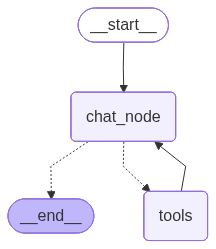

In [79]:
graph = StateGraph(chatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")

workflow = graph.compile()
workflow

In [80]:
output = workflow.invoke({"messages": [HumanMessage(content="whats the 2*3")]})
output['messages'][-1].content

'The result of 2*3 is 6.'

In [81]:
output = workflow.invoke({"messages": [HumanMessage(content="Does RCB Wins in 2025? what cup RCB Wins?")]})
output['messages'][-1].content

'RCB wins the Indian Premier League (IPL) in 2025. They defeated Punjab Kings by 6 runs in the final to secure their first-ever IPL title.'